In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import os
import datetime as dt
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import cmocean
import json
import f90nml
from collections import OrderedDict
from scipy.stats.mstats import gmean
import netCDF4 as nc

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display



%matplotlib inline

In [13]:
df1 = pd.read_excel('nutrients_2018dfo.xlsx',parse_dates=['dtUTC'])

In [ ]:
start_date = dt.datetime(2018,2,26)
end_date = dt.datetime(2018,8,31)
flen=1
PATH = '/results2/SalishSea/nowcast-green.202111' 
#PATH = '/home/jvalenti/scratch/run_SHEM/tuning/pred_flag'
namfmt='nowcast'
filemap={'nitrate':'biol_T','silicon':'biol_T','ammonium':'biol_T','diatoms':'biol_T',
        'flagellates':'biol_T'}
fdict={'biol_T':24}

In [3]:
M_path = '/home/jvalenti/MOAD/'
mask_path = M_path+'grid2/mesh_mask202108_TDV.nc'

In [ ]:
#data=et.matchData(df1,filemap,fdict,mask_path,mod_start=start_date,mod_end=end_date,mod_basedir=PATH,mod_nam_fmt='shem')

mod_start=2018-02-26 00:00:00
mod_end=2018-08-31 00:00:00


In [ ]:
#data.to_excel('nutrients202111_1d.xlsx')

In [5]:
#data = pd.read_excel('nutrientsshem.xlsx',parse_dates=['dtUTC'])
data = pd.read_excel('nutrients202111_1d.xlsx',parse_dates=['dtUTC'])
data = pd.read_excel('nutrientsSHEM_predflag.xlsx',parse_dates=['dtUTC'])
year = 2018

In [ ]:
# report coefficients used in 
try:
    nml=f90nml.read(os.path.join(PATH,'01jan'+str(year)[-2:],'namelist_smelt_cfg'))
    mod_chl_N=nml['nampisopt']['zzn2chl']
    print('Parameter values from 01jan'+str(year)[-2:]+' namelist_smelt_cfg:')
    print('   Chl:N = ',mod_chl_N)
    print('   zz_bfsi = ',nml['nampisrem']['zz_bfsi'])
    print('   zz_remin_d_bsi = ',nml['nampisrem']['zz_remin_d_bsi'])
    print('   zz_w_sink_d_bsi = ',nml['nampissink']['zz_w_sink_d_bsi'])
    print('   zz_alpha_b_si = ',nml['nampissink']['zz_alpha_b_si'])
    print('   zz_alpha_b_d = ',nml['nampissink']['zz_alpha_b_d'])
except:
    print('namelist_smelt_cfg not present in results file')

namelist_smelt_cfg not present in results file


In [10]:
# chlorophyll calculations
mod_chl_N = 2
data['l10_obsChl']=np.log10(data['Chlorophyll_Extracted']+0.01)
data['l10_modChl']=np.log10(mod_chl_N*(data['mod_diatoms']+data['mod_flagellates'])+0.01)
data['mod_Chl']=mod_chl_N*(data['mod_diatoms']+data['mod_flagellates'])
data['Chl']=data['Chlorophyll_Extracted']

In [11]:
def byDepth(ax,obsvar,modvar,lims):
    ps=et.varvarPlot(ax,data,obsvar,modvar,'Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
    l=ax.legend(handles=ps)
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return ps,l

def byRegion(ax,obsvar,modvar,lims):
    ps1=et.varvarPlot(ax,dJDF,obsvar,modvar,cols=('b',),lname='SJDF')
    ps2=et.varvarPlot(ax,dSJGI,obsvar,modvar,cols=('c',),lname='SJGI')
    ps3=et.varvarPlot(ax,dSOG,obsvar,modvar,cols=('y',),lname='SOG')
    ps4=et.varvarPlot(ax,dNSOG,obsvar,modvar,cols=('m',),lname='NSOG')
    l=ax.legend(handles=[ps1[0][0],ps2[0][0],ps3[0][0],ps4[0][0]])
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return (ps1,ps2,ps3,ps4),l

def bySeason(ax,obsvar,modvar,lims):
    for axi in ax:
        axi.plot(lims,lims,'k-')
        axi.set_xlim(lims)
        axi.set_ylim(lims)
        axi.set_aspect(1)
        axi.set_xlabel('Obs')
        axi.set_ylabel('Model')
    ps=et.varvarPlot(ax[0],JFM,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[0].set_title('Jan-Mar')
    ps=et.varvarPlot(ax[1],Apr,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[1].set_title('Apr')
    ps=et.varvarPlot(ax[2],MJJA,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[2].set_title('May-Aug')
    ps=et.varvarPlot(ax[3],SOND,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[3].set_title('Sep-Dec')
    return 

def ErrErr(fig,ax,obsvar1,modvar1,obsvar2,modvar2,lims1,lims2):
    m=ax.scatter(data[modvar1]-data[obsvar1],data[modvar2]-data[obsvar2],c=data['Z'],s=1,cmap='gnuplot')
    cb=fig.colorbar(m,ax=ax,label='Depth (m)')
    ax.set_xlim(lims1)
    ax.set_ylim(lims2)
    ax.set_aspect((lims1[1]-lims1[0])/(lims2[1]-lims2[0]))
    return m,cb

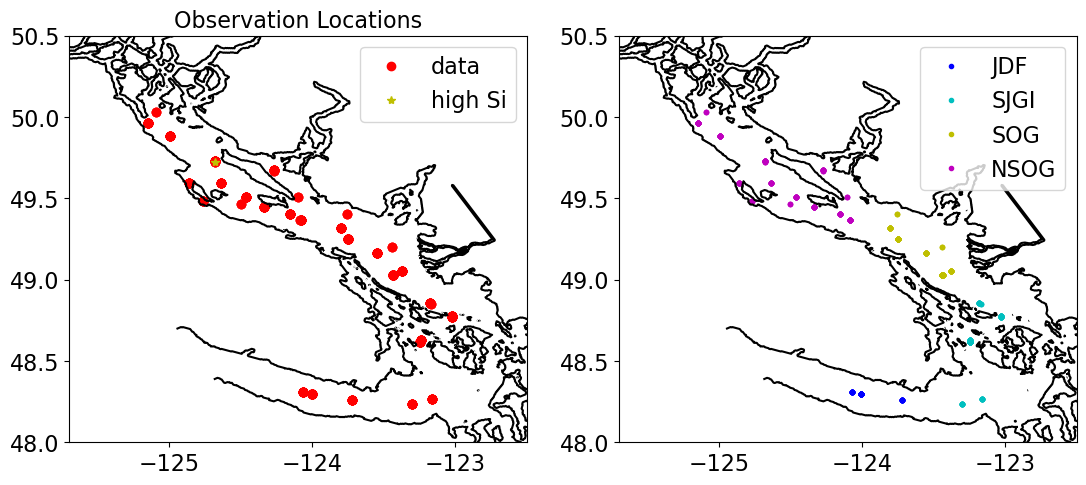

In [12]:
fig, ax = plt.subplots(1,2,figsize = (13,6))
viz_tools.set_aspect(ax[0], coords = 'map')
ax[0].plot(data['Lon'], data['Lat'], 'ro',label='data')
ax[0].plot(data.loc[data.Si>75,['Lon']],data.loc[data.Si>75,['Lat']],'*',color='y',label='high Si')
grid = nc.Dataset('/home/jvalenti/MOAD/grid/bathymetry_202108.nc')
viz_tools.plot_coastline(ax[0], grid, coords = 'map',isobath=.1)
ax[0].set_ylim(48, 50.5)
ax[0].legend()
ax[0].set_xlim(-125.7, -122.5);
ax[0].set_title('Observation Locations');

viz_tools.set_aspect(ax[1], coords = 'map')
#ax[1].plot(data['Lon'], data['Lat'], 'ro',label='data')
dJDF=data.loc[(data.Lon<-123.6)&(data.Lat<48.6)]
ax[1].plot(dJDF['Lon'],dJDF['Lat'],'b.',label='JDF')
dSJGI=data.loc[(data.Lon>=-123.6)&(data.Lat<48.9)]
ax[1].plot(dSJGI['Lon'],dSJGI['Lat'],'c.',label='SJGI')
dSOG=data.loc[(data.Lat>=48.9)&(data.Lon>-124.0)]
ax[1].plot(dSOG['Lon'],dSOG['Lat'],'y.',label='SOG')
dNSOG=data.loc[(data.Lat>=48.9)&(data.Lon<=-124.0)]
ax[1].plot(dNSOG['Lon'],dNSOG['Lat'],'m.',label='NSOG')
viz_tools.plot_coastline(ax[1], grid, coords = 'map')
ax[1].set_ylim(48, 50.5)
ax[1].legend()
ax[1].set_xlim(-125.7, -122.5);

# Also set up seasonal groupings:
iz=(data.Z<15)
JFM=data.loc[iz&(data.dtUTC<=dt.datetime(year,4,1)),:]
Apr=data.loc[iz&(data.dtUTC<=dt.datetime(year,5,1))&(data.dtUTC>dt.datetime(year,4,1)),:]
MJJA=data.loc[iz&(data.dtUTC<=dt.datetime(year,9,1))&(data.dtUTC>dt.datetime(year,5,1)),:]
SOND=data.loc[iz&(data.dtUTC>dt.datetime(year,9,1)),:]

In [15]:
statsubs=OrderedDict({'z < 15 m':data.loc[data.Z<15],
                      '15 m < z < 22 m':data.loc[(data.Z>=15)&(data.Z<22)],
                      'z >= 22 m':data.loc[data.Z>=22],
                      'z > 50 m':data.loc[data.Z>50],
                      'all':data,
                      'z < 15 m, JFM':JFM,
                      'z < 15 m, Apr':Apr,
                      'z < 15 m, MJJA':MJJA,
                      'z < 15 m, SOND': SOND})

In [16]:
# prep and load dictionary to save stats in
if os.path.isfile('vET-HC1905-DFO-NutChlPhys-stats.json'):
    with open('vET-HC1905-DFO-NutChlPhys-stats.json', 'r') as fstat:
        statsDict = json.load(fstat);
    statsDict[year]=dict();    
else:
    statsDict={year:dict()};

### Nitrate

In [17]:
obsvar='N'
modvar='mod_nitrate'
statsDict[year]['NO3']=OrderedDict()
for isub in statsubs:
    statsDict[year]['NO3'][isub]=dict()
    var=statsDict[year]['NO3'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict[year]['NO3'],level='Subset',suborder=list(statsubs.keys()))
tbl

In [23]:
np.min(data[modvar])

17.22900581359863

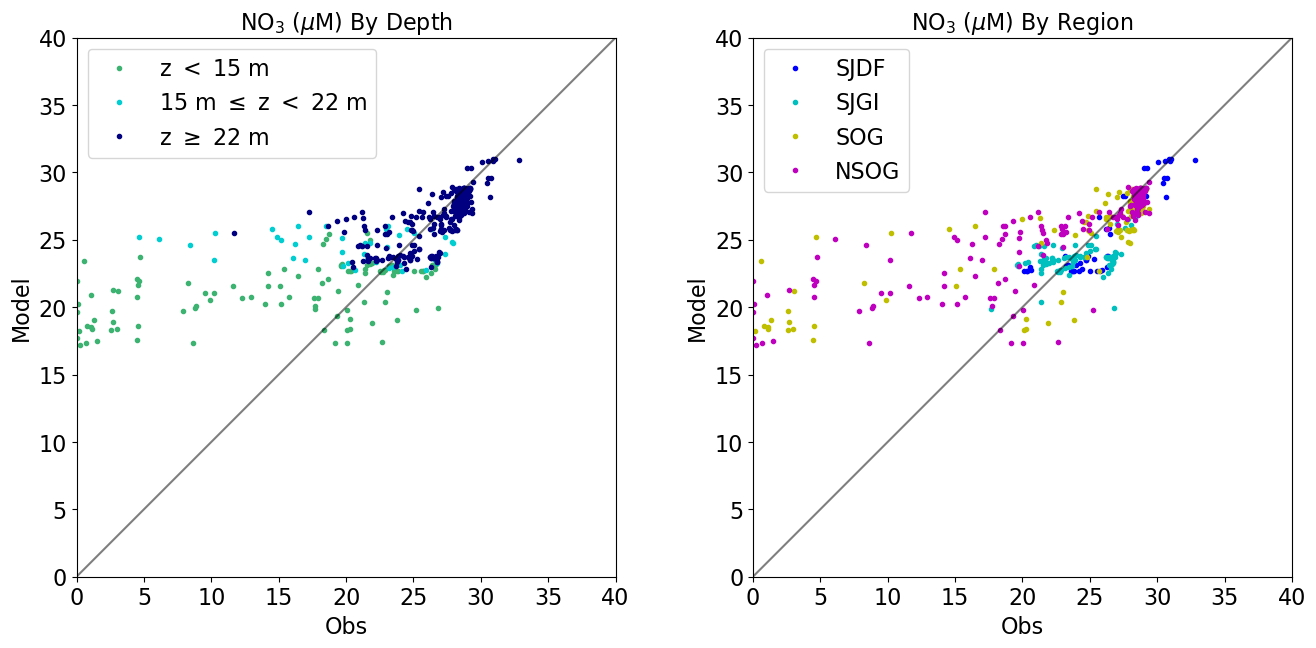

In [18]:
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=byDepth(ax[0],obsvar,modvar,(0,40))
ax[0].set_title('NO$_3$ ($\mu$M) By Depth')

ps,l=byRegion(ax[1],obsvar,modvar,(0,40))
ax[1].set_title('NO$_3$ ($\mu$M) By Region');

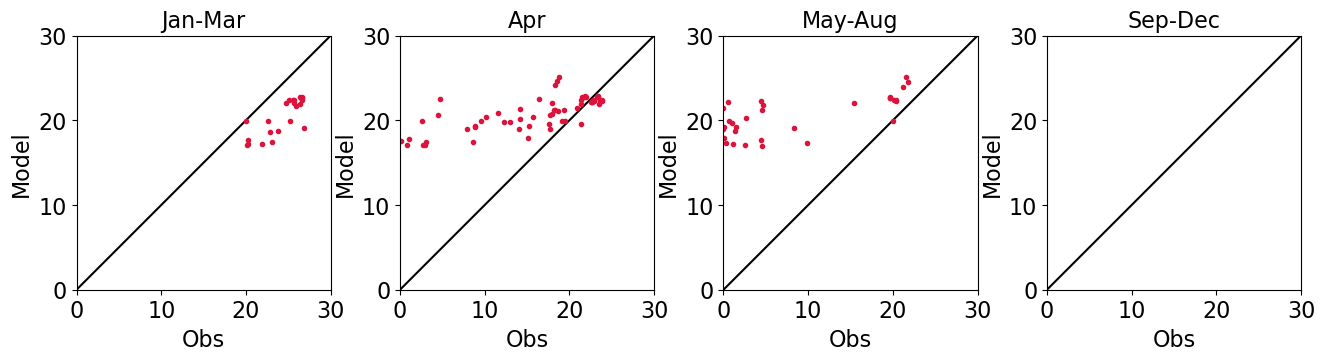

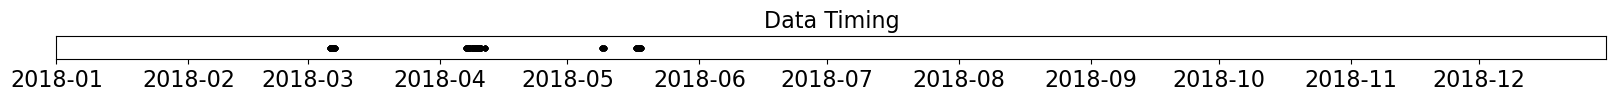

In [34]:
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,obsvar,modvar,(0,30))
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('Data Timing')
ax.yaxis.set_visible(False)

### Dissolved Silica

In [35]:
obsvar='Si'
modvar='mod_silicon'
statsDict[year]['dSi']=OrderedDict()
for isub in statsubs:
    statsDict[year]['dSi'][isub]=dict()
    var=statsDict[year]['dSi'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict[year]['dSi'],level='Subset',suborder=list(statsubs.keys()))
tbl

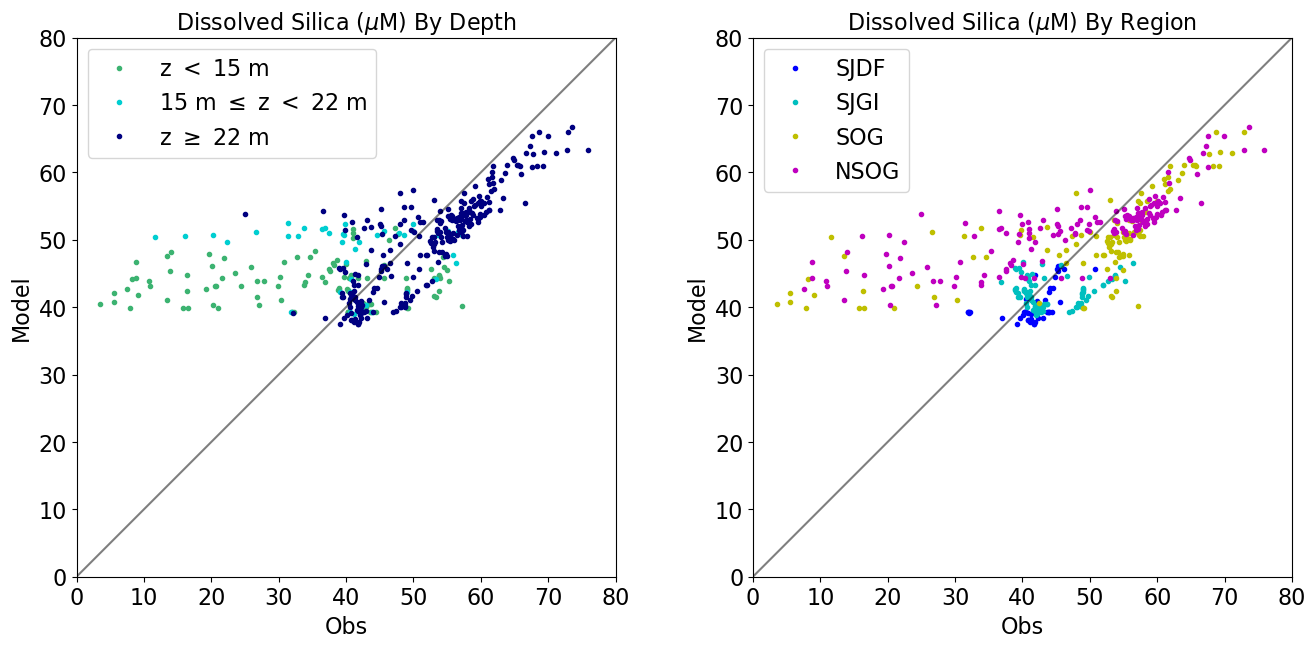

In [36]:
mv=(0,80)
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=byDepth(ax[0],obsvar,modvar,mv)
ax[0].set_title('Dissolved Silica ($\mu$M) By Depth')

ps,l=byRegion(ax[1],obsvar,modvar,mv)
ax[1].set_title('Dissolved Silica ($\mu$M) By Region');

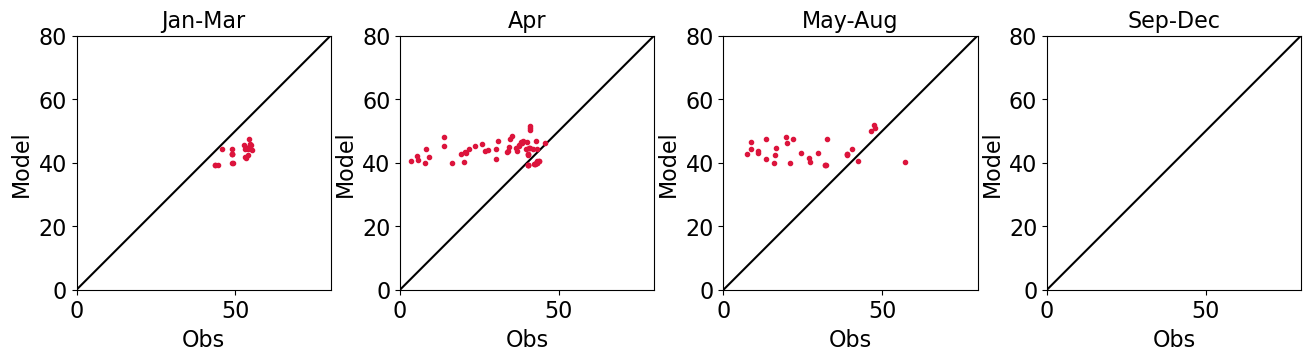

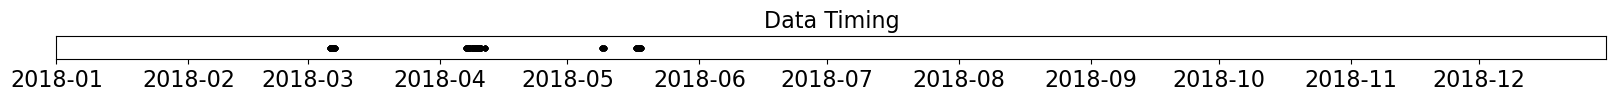

In [37]:
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,obsvar,modvar,mv)
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('Data Timing')
ax.yaxis.set_visible(False)

Text(0.5, 1.0, 'dSi')

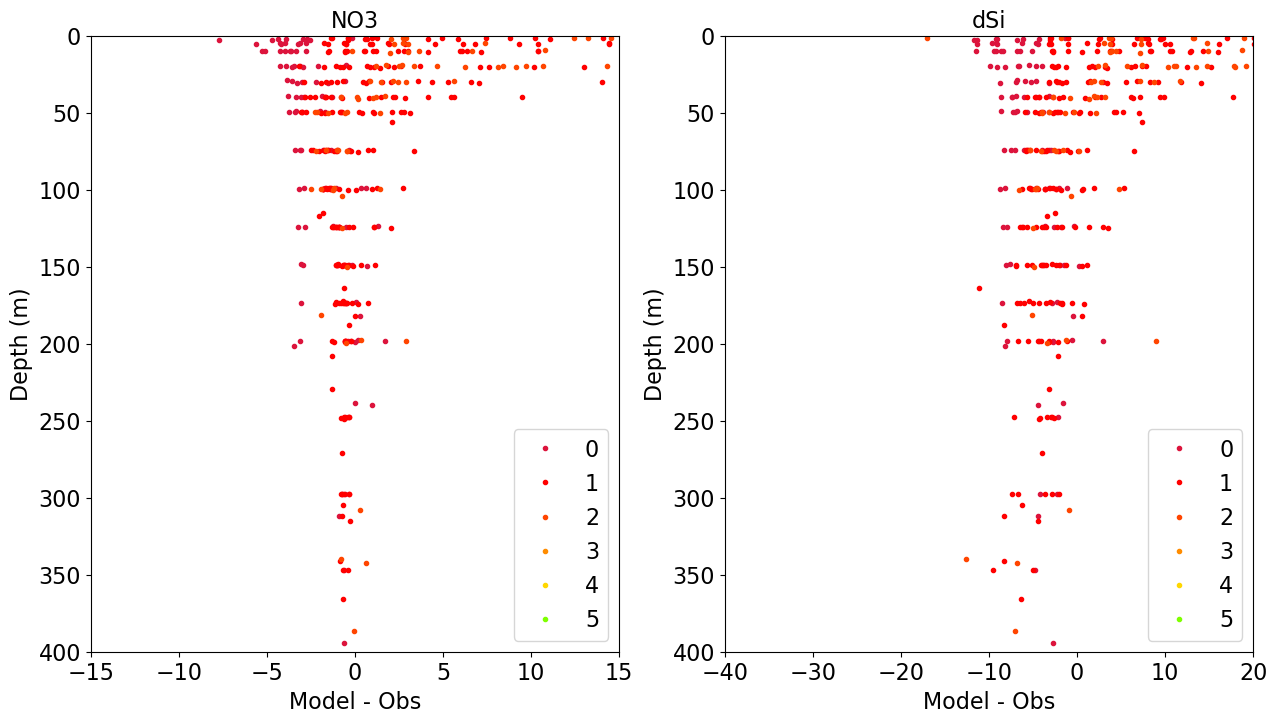

In [38]:
fig, ax = plt.subplots(1,2,figsize = (15,8))
cols=('crimson','red','orangered','darkorange','gold','chartreuse','green','lightseagreen','cyan',
      'darkturquoise','royalblue','lightskyblue','blue','darkblue','mediumslateblue','blueviolet',
      'darkmagenta','fuchsia','deeppink','pink')
ii0=start_date
for ii in range(0,int((end_date-start_date).days/30)):
    iii=(data.dtUTC>=(start_date+dt.timedelta(days=ii*30)))&(data.dtUTC<(start_date+dt.timedelta(days=(ii+1)*30)))
    ax[0].plot(data.loc[iii,['mod_nitrate']].values-data.loc[iii,['N']].values, data.loc[iii,['Z']].values, 
        '.', color = cols[ii],label=str(ii))
    ax[1].plot(data.loc[iii,['mod_silicon']].values-data.loc[iii,['Si']].values, data.loc[iii,['Z']].values, 
        '.', color = cols[ii],label=str(ii))
for axi in (ax[0],ax[1]):
    axi.legend(loc=4)
    axi.set_ylim(400,0)
    axi.set_ylabel('Depth (m)')
ax[0].set_xlabel('Model - Obs')
ax[1].set_xlabel('Model - Obs')
ax[0].set_xlim(-15,15)
ax[1].set_xlim(-40,20)
ax[0].set_title('NO3')
ax[1].set_title('dSi')

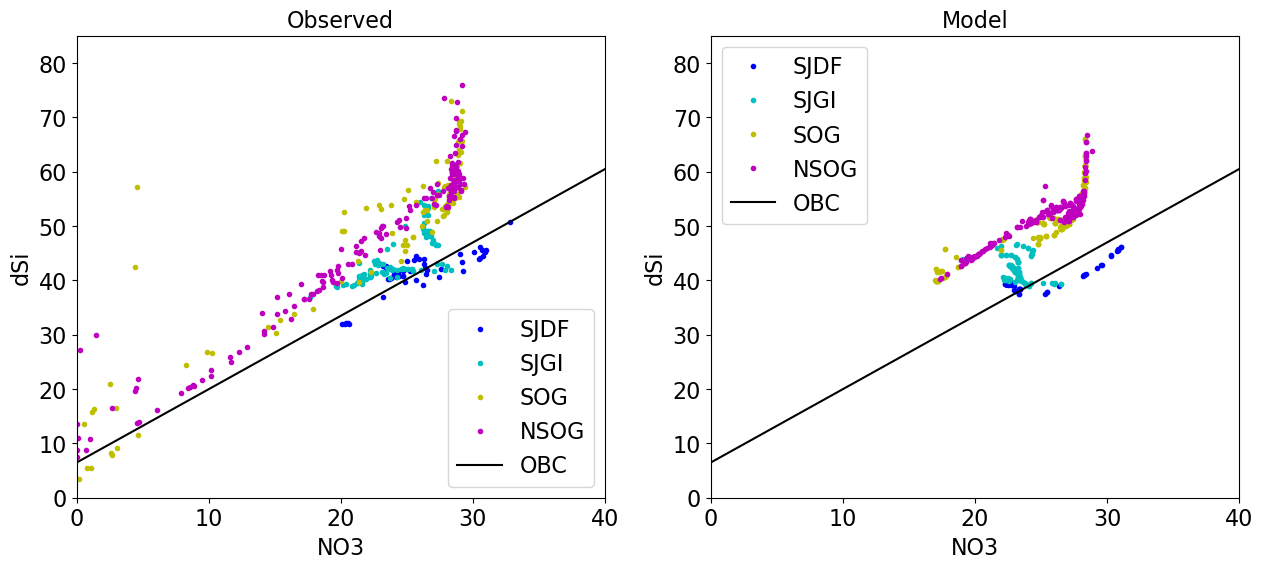

In [39]:
fig,ax=plt.subplots(1,2,figsize=(15,6))
p1=ax[0].plot(dJDF['N'],dJDF['Si'],'b.',label='SJDF')
p2=ax[0].plot(dSJGI['N'],dSJGI['Si'],'c.',label='SJGI')
p3=ax[0].plot(dSOG['N'],dSOG['Si'],'y.',label='SOG')
p4=ax[0].plot(dNSOG['N'],dNSOG['Si'],'m.',label='NSOG')
ax[0].plot(np.arange(0,41),1.35*np.arange(0,41)+6.46,'k-',label='OBC')
ax[0].set_title('Observed')
ax[0].set_xlabel('NO3')
ax[0].set_ylabel('dSi')
ax[0].set_xlim(0,40)
ax[0].set_ylim(0,85)
ax[0].legend()

p5=ax[1].plot(dJDF['mod_nitrate'],dJDF['mod_silicon'],'b.',label='SJDF')
p6=ax[1].plot(dSJGI['mod_nitrate'],dSJGI['mod_silicon'],'c.',label='SJGI')
p7=ax[1].plot(dSOG['mod_nitrate'],dSOG['mod_silicon'],'y.',label='SOG')
p8=ax[1].plot(dNSOG['mod_nitrate'],dNSOG['mod_silicon'],'m.',label='NSOG')
ax[1].plot(np.arange(0,41),1.35*np.arange(0,41)+6.46,'k-',label='OBC')
ax[1].set_title('Model')
ax[1].set_xlabel('NO3')
ax[1].set_ylabel('dSi')
ax[1].set_xlim(0,40)
ax[1].set_ylim(0,85)
ax[1].legend()
#ax[0].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')
#ax[1].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')

### Chlorophyll

In [40]:
obsvar='l10_obsChl'
modvar='l10_modChl'
statsDict[year]['Chl log10']=OrderedDict()
for isub in statsubs:
    statsDict[year]['Chl log10'][isub]=dict()
    var=statsDict[year]['Chl log10'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
obsvar='Chlorophyll_Extracted'
modvar='mod_Chl'
statsDict[year]['Chl']=OrderedDict()
for isub in statsubs:
    statsDict[year]['Chl'][isub]=dict()
    var=statsDict[year]['Chl'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])

tempD={'Chl log10':statsDict[year]['Chl log10'],'Chl':statsDict[year]['Chl']}
tbl,tdf=et.displayStatsFlex(tempD,('Variable','Subset','Metric',''),
                        ['Order','Subset','Metric'],
                        ['Variable','Metric'],
                        suborder=list(statsubs.keys()))
tbl

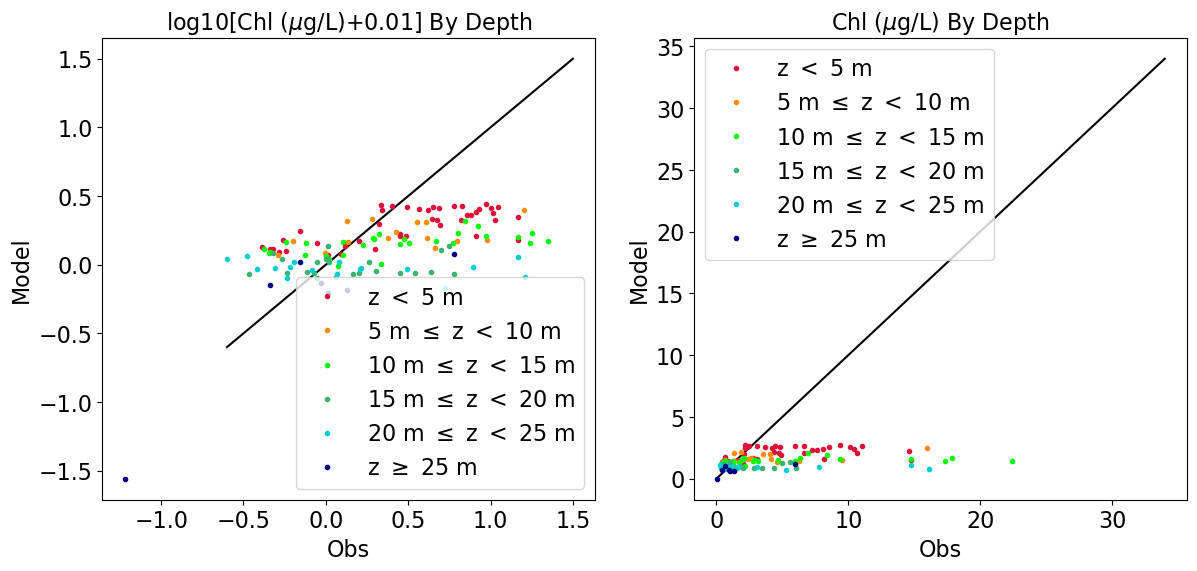

In [41]:
fig, ax = plt.subplots(1,2,figsize = (14,6))
ax[0].plot(np.arange(-.6,1.6,.1),np.arange(-.6,1.6,.1),'k-')
ps=et.varvarPlot(ax[0],data,'l10_obsChl','l10_modChl','Z',(5,10,15,20,25),'z','m',('crimson','darkorange','lime','mediumseagreen','darkturquoise','navy'))
ax[0].legend(handles=ps)
ax[0].set_xlabel('Obs')
ax[0].set_ylabel('Model')
ax[0].set_title('log10[Chl ($\mu$g/L)+0.01] By Depth')
ax[1].plot(np.arange(0,35),np.arange(0,35),'k-')
ps=et.varvarPlot(ax[1],data,'Chlorophyll_Extracted','mod_Chl','Z',(5,10,15,20,25),'z','m',('crimson','darkorange','lime','mediumseagreen','darkturquoise','navy'))
ax[1].legend(handles=ps)
ax[1].set_xlabel('Obs')
ax[1].set_ylabel('Model')
ax[1].set_title('Chl ($\mu$g/L) By Depth');

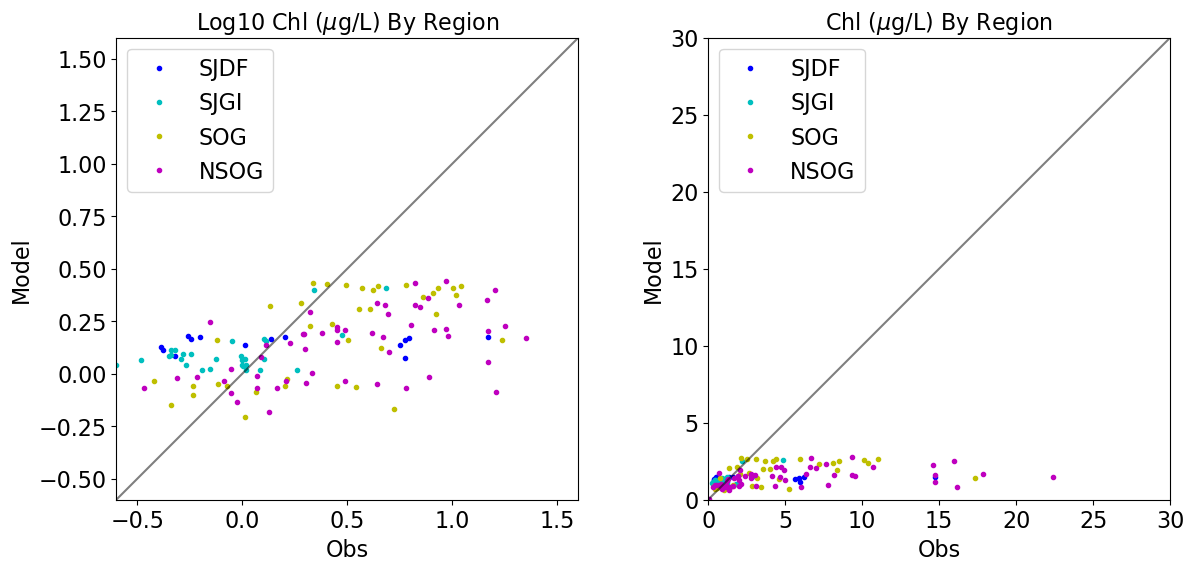

In [42]:
fig, ax = plt.subplots(1,2,figsize = (14,6))
obsvar='l10_obsChl'; modvar='l10_modChl'
ps,l=byRegion(ax[0],obsvar,modvar,(-.6,1.6))
ax[0].set_title('Log10 Chl ($\mu$g/L) By Region');

obsvar='Chlorophyll_Extracted'; modvar='mod_Chl'
ps,l=byRegion(ax[1],obsvar,modvar,(0,30))
ax[1].set_title('Chl ($\mu$g/L) By Region');